# Test Delight on DESC-DC2 simulation  in the context of  Vera C. Rubin Obs (LSST) 
## Run by chunk

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : January 22 2022



- run at NERSC with **desc-python** python kernel.


Instruction to have a **desc-python** environnement:
- https://confluence.slac.stanford.edu/display/LSSTDESC/Getting+Started+with+Anaconda+Python+at+NERSC


This environnement is a clone from the **desc-python** environnement where package required in requirements can be addded according the instructions here
- https://github.com/LSSTDESC/desc-python/wiki/Add-Packages-to-the-desc-python-environment

We will use the parameter file "tmps/parametersTestRail.cfg".
This contains a description of the bands and data to be used.
In this example we will generate mock data for the ugrizy LSST bands,
fit each object with our GP using ugi bands only and see how it predicts the rz bands.
This is an example for filling in/predicting missing bands in a fully bayesian way
with a flexible SED model quickly via our photo-z GP.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sys,os
sys.path.append('../')
from delight.io import *
from delight.utils import *
from delight.photoz_gp import PhotozGP

In [45]:
from matplotlib.colors import LogNorm

In [46]:
import logging
import coloredlogs
logger = logging.getLogger(__name__)
coloredlogs.install(level='DEBUG', logger=logger,fmt='%(asctime)s,%(msecs)03d %(programname)s %(name)s[%(process)d] %(levelname)s %(message)s')

In [47]:
print(sys.executable)
print(sys.version)
#print(sys.version_info)

/global/homes/d/dagoret/mydesc/mydesc/bin/python
3.8.12 | packaged by conda-forge | (default, Oct 12 2021, 21:59:51) 
[GCC 9.4.0]


In [48]:
plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

# Initialisation

In [2]:
workdir = "tmp"

# Configuration parameters

- now parameters are generated in a dictionnary

In [3]:
list_of_files = os.listdir(workdir)
list_of_files.remove('data') 
list_of_files.remove('delight_data') 
if '.ipynb_checkpoints' in list_of_files:
    list_of_files.remove('.ipynb_checkpoints')
    
list_of_configfiles = sorted(list_of_files)

In [4]:
list_of_configfiles

['parametersTest.cfg',
 'parametersTest_1.cfg',
 'parametersTest_10.cfg',
 'parametersTest_11.cfg',
 'parametersTest_12.cfg',
 'parametersTest_13.cfg',
 'parametersTest_14.cfg',
 'parametersTest_15.cfg',
 'parametersTest_16.cfg',
 'parametersTest_17.cfg',
 'parametersTest_18.cfg',
 'parametersTest_19.cfg',
 'parametersTest_2.cfg',
 'parametersTest_20.cfg',
 'parametersTest_21.cfg',
 'parametersTest_3.cfg',
 'parametersTest_4.cfg',
 'parametersTest_5.cfg',
 'parametersTest_6.cfg',
 'parametersTest_7.cfg',
 'parametersTest_8.cfg',
 'parametersTest_9.cfg']

In [5]:
NCHUNKS = len(list_of_configfiles)


# Filters

- First, we must **fit the band filters with a gaussian mixture**. 
This is done with this script:

In [6]:
from delight.interfaces.rail.processFilters import processFilters

In [7]:
configfilename = list_of_configfiles[0]
configfullfilename = os.path.join(workdir,configfilename) 
processFilters(configfullfilename)

2022-01-22 10:06:19,347 __main__.py delight.interfaces.rail.processFilters[5644] INFO ----- processFilters ------
2022-01-22 10:06:19,348 __main__.py delight.interfaces.rail.processFilters[5644] INFO parameter file is tmp/parametersTest.cfg


DC2LSST_u DC2LSST_g DC2LSST_r DC2LSST_i DC2LSST_z DC2LSST_y 

# SED

- Second, we will process the library of SEDs and project them onto the filters,
(for the mean fct of the GP) with the following script (which may take a few minutes depending on the settings you set):

In [8]:
from delight.interfaces.rail.processSEDs import processSEDs

In [9]:
configfilename = list_of_configfiles[0]
configfullfilename = os.path.join(workdir,configfilename) 
processSEDs(configfullfilename)

2022-01-22 10:06:43,338 __main__.py, delight.interfaces.rail.processSEDs[5644] INFO --- Process SED ---


# Train and apply
Run the scripts below. There should be a little bit of feedback as it is going through the lines.
For up to 1e4 objects it should only take a few minutes max, depending on the settings above.

## Template Fitting

In [10]:
from delight.interfaces.rail.templateFitting import templateFitting

In [12]:
for idx_file in range(1,NCHUNKS):
    theconfigfile = list_of_configfiles[idx_file]
    configfullfilename = os.path.join(workdir,theconfigfile) 
    templateFitting(configfullfilename)

2022-01-22 10:10:16,372 __main__.py, delight.interfaces.rail.templateFitting[5644] INFO --- TEMPLATE FITTING ---
2022-01-22 10:10:16,373 __main__.py, delight.interfaces.rail.templateFitting[5644] INFO ==> New Prior calculation from Benitez
2022-01-22 10:10:16,375 __main__.py, delight.interfaces.rail.templateFitting[5644] INFO Thread number / number of threads: 1 , 1
2022-01-22 10:10:16,376 __main__.py, delight.interfaces.rail.templateFitting[5644] INFO Input parameter file:tmp/parametersTest_1.cfg
2022-01-22 10:10:16,401 __main__.py, delight.interfaces.rail.templateFitting[5644] INFO Number of Target Objects 507
2022-01-22 10:10:16,401 __main__.py, delight.interfaces.rail.templateFitting[5644] INFO Thread 0 , analyzes lines 0 , to 507
2022-01-22 10:10:24,041 __main__.py, delight.interfaces.rail.templateFitting[5644] INFO --- TEMPLATE FITTING ---
2022-01-22 10:10:24,042 __main__.py, delight.interfaces.rail.templateFitting[5644] INFO ==> New Prior calculation from Benitez
2022-01-22 10:1

## Gaussian Process

### Trainning

In [15]:
from delight.interfaces.rail.delightLearn import delightLearn

In [16]:
delightLearn(configfullfilename)

2022-01-22 10:13:30,253 __main__.py, delight.interfaces.rail.delightLearn[5644] INFO --- DELIGHT-LEARN ---
2022-01-22 10:13:30,285 __main__.py, delight.interfaces.rail.delightLearn[5644] INFO Number of Training Objects 3755
2022-01-22 10:13:30,285 __main__.py, delight.interfaces.rail.delightLearn[5644] INFO Thread 0 , analyzes lines 0 , to 3755


## Predictions

In [17]:
from delight.interfaces.rail.delightApply import delightApply

In [18]:
for idx_file in range(1,NCHUNKS):
    theconfigfile = list_of_configfiles[idx_file]
    configfullfilename = os.path.join(workdir,theconfigfile) 
    delightApply(configfullfilename)

2022-01-22 10:14:53,352 __main__.py, delight.interfaces.rail.delightApply[5644] INFO --- DELIGHT-APPLY ---
2022-01-22 10:14:53,407 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Training Objects 3755
2022-01-22 10:14:53,407 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Target Objects 507
2022-01-22 10:14:53,408 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Thread 0 , analyzes lines 0 to 507


0 0.03676795959472656 0.0009353160858154297 0.018759727478027344
100 0.02809286117553711 0.0010118484497070312 0.013250589370727539
200 0.024448871612548828 0.0008194446563720703 0.00882267951965332
300 0.03964853286743164 0.0010242462158203125 0.020501375198364258
400 0.027206897735595703 0.0009641647338867188 0.0073490142822265625
500 0.034952402114868164 0.001058340072631836 0.017778873443603516


2022-01-22 10:16:27,532 __main__.py, delight.interfaces.rail.delightApply[5644] INFO --- DELIGHT-APPLY ---
2022-01-22 10:16:27,582 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Training Objects 3755
2022-01-22 10:16:27,583 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Target Objects 361
2022-01-22 10:16:27,583 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Thread 0 , analyzes lines 0 to 361


0 0.020628690719604492 0.0011861324310302734 0.008957386016845703
100 0.017569780349731445 0.0007045269012451172 0.0064890384674072266
200 0.018210411071777344 0.0006575584411621094 0.010647773742675781
300 0.017454862594604492 0.0005888938903808594 0.009106159210205078


2022-01-22 10:17:48,706 __main__.py, delight.interfaces.rail.delightApply[5644] INFO --- DELIGHT-APPLY ---
2022-01-22 10:17:48,756 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Training Objects 3755
2022-01-22 10:17:48,757 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Target Objects 415
2022-01-22 10:17:48,757 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Thread 0 , analyzes lines 0 to 415


0 0.024659395217895508 0.0006823539733886719 0.019608020782470703
100 0.021656513214111328 0.0008347034454345703 0.009239912033081055
200 0.022698640823364258 0.0008020401000976562 0.011307716369628906
300 0.019404172897338867 0.0006208419799804688 0.011021852493286133
400 0.020730972290039062 0.0007834434509277344 0.007568836212158203


2022-01-22 10:19:12,490 __main__.py, delight.interfaces.rail.delightApply[5644] INFO --- DELIGHT-APPLY ---
2022-01-22 10:19:12,541 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Training Objects 3755
2022-01-22 10:19:12,541 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Target Objects 448
2022-01-22 10:19:12,542 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Thread 0 , analyzes lines 0 to 448


0 0.03660225868225098 0.0009267330169677734 0.01266622543334961
100 0.02550363540649414 0.0012042522430419922 0.014926671981811523
200 0.02347731590270996 0.0009069442749023438 0.008074045181274414
300 0.02318429946899414 0.0010538101196289062 0.007005214691162109
400 0.02452850341796875 0.0009968280792236328 0.006235837936401367


2022-01-22 10:20:39,755 __main__.py, delight.interfaces.rail.delightApply[5644] INFO --- DELIGHT-APPLY ---
2022-01-22 10:20:39,807 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Training Objects 3755
2022-01-22 10:20:39,808 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Target Objects 501
2022-01-22 10:20:39,809 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Thread 0 , analyzes lines 0 to 501


0 0.05250191688537598 0.0015096664428710938 0.018357276916503906
100 0.03400754928588867 0.0011301040649414062 0.006659030914306641
200 0.026601314544677734 0.0009746551513671875 0.009493112564086914
300 0.02631068229675293 0.0009951591491699219 0.0061528682708740234
400 0.026457786560058594 0.0011565685272216797 0.009207963943481445


2022-01-22 10:22:13,077 __main__.py, delight.interfaces.rail.delightApply[5644] INFO --- DELIGHT-APPLY ---
2022-01-22 10:22:13,129 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Training Objects 3755
2022-01-22 10:22:13,129 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Target Objects 630
2022-01-22 10:22:13,130 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Thread 0 , analyzes lines 0 to 630


500 0.025677919387817383 0.0009167194366455078 0.00811147689819336
0 0.04226398468017578 0.0012962818145751953 0.009132862091064453
100 0.033406972885131836 0.00121307373046875 0.007157325744628906
200 0.03412628173828125 0.0010628700256347656 0.012706756591796875
300 0.03316187858581543 0.0015289783477783203 0.005980014801025391
400 0.03372025489807129 0.001489877700805664 0.006322622299194336
500 0.03497505187988281 0.0013120174407958984 0.00787496566772461
600 0.036289215087890625 0.0011768341064453125 0.014076709747314453


2022-01-22 10:23:56,651 __main__.py, delight.interfaces.rail.delightApply[5644] INFO --- DELIGHT-APPLY ---
2022-01-22 10:23:56,703 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Training Objects 3755
2022-01-22 10:23:56,706 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Target Objects 713
2022-01-22 10:23:56,706 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Thread 0 , analyzes lines 0 to 713


0 0.04590487480163574 0.0010938644409179688 0.015599727630615234
100 0.03805255889892578 0.0013501644134521484 0.007100582122802734
200 0.03931856155395508 0.0016901493072509766 0.009451627731323242
300 0.034078359603881836 0.0011200904846191406 0.013106346130371094
400 0.035698890686035156 0.0010440349578857422 0.011176824569702148
500 0.03616142272949219 0.0011167526245117188 0.008363008499145508
600 0.03580617904663086 0.0010137557983398438 0.014904499053955078
700 0.03627657890319824 0.0011830329895019531 0.009616613388061523


2022-01-22 10:25:45,974 __main__.py, delight.interfaces.rail.delightApply[5644] INFO --- DELIGHT-APPLY ---
2022-01-22 10:25:46,024 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Training Objects 3755
2022-01-22 10:25:46,025 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Target Objects 826
2022-01-22 10:25:46,025 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Thread 0 , analyzes lines 0 to 826


0 0.04983377456665039 0.0014488697052001953 0.007536411285400391
100 0.04770708084106445 0.001779794692993164 0.009997844696044922
200 0.0475766658782959 0.0014286041259765625 0.012638092041015625
300 0.04435229301452637 0.0014071464538574219 0.009919881820678711
400 0.04366755485534668 0.0015540122985839844 0.009192943572998047
500 0.041831254959106445 0.001440286636352539 0.009196758270263672
600 0.043413400650024414 0.0015015602111816406 0.00625920295715332
700 0.039877891540527344 0.0012879371643066406 0.014200210571289062
800 0.04719805717468262 0.0016379356384277344 0.010362625122070312


2022-01-22 10:27:48,259 __main__.py, delight.interfaces.rail.delightApply[5644] INFO --- DELIGHT-APPLY ---
2022-01-22 10:27:48,309 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Training Objects 3755
2022-01-22 10:27:48,310 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Target Objects 830
2022-01-22 10:27:48,310 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Thread 0 , analyzes lines 0 to 830


0 0.05625128746032715 0.0014467239379882812 0.010144472122192383
100 0.04511880874633789 0.001773834228515625 0.007776975631713867
200 0.043822288513183594 0.0014965534210205078 0.006003856658935547
300 0.044304609298706055 0.0015370845794677734 0.006957054138183594
400 0.04273271560668945 0.001337289810180664 0.007275104522705078
500 0.06456136703491211 0.0015091896057128906 0.013912200927734375
600 0.04423928260803223 0.001310586929321289 0.006389617919921875
700 0.04357624053955078 0.0016815662384033203 0.006325483322143555
800 0.0421750545501709 0.001600027084350586 0.007267951965332031


2022-01-22 10:29:48,539 __main__.py, delight.interfaces.rail.delightApply[5644] INFO --- DELIGHT-APPLY ---
2022-01-22 10:29:48,594 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Training Objects 3755
2022-01-22 10:29:48,596 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Target Objects 826
2022-01-22 10:29:48,597 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Thread 0 , analyzes lines 0 to 826


0 0.05701851844787598 0.0016603469848632812 0.008117437362670898
100 0.045443058013916016 0.0014307498931884766 0.006428956985473633
200 0.046187639236450195 0.0016674995422363281 0.006333827972412109
300 0.04886341094970703 0.001631021499633789 0.006445407867431641
400 0.04533696174621582 0.0016107559204101562 0.00901937484741211
500 0.045487165451049805 0.0014281272888183594 0.005098819732666016
600 0.046576499938964844 0.0016162395477294922 0.009129047393798828
700 0.06744766235351562 0.0017027854919433594 0.0076296329498291016
800 0.04265880584716797 0.0014531612396240234 0.014298677444458008


2022-01-22 10:31:49,600 __main__.py, delight.interfaces.rail.delightApply[5644] INFO --- DELIGHT-APPLY ---
2022-01-22 10:31:49,689 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Training Objects 3755
2022-01-22 10:31:49,690 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Target Objects 854
2022-01-22 10:31:49,690 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Thread 0 , analyzes lines 0 to 854


0 0.05144762992858887 0.0015108585357666016 0.006552696228027344
100 0.04349875450134277 0.0014698505401611328 0.0059871673583984375
200 0.04291248321533203 0.0015714168548583984 0.006472349166870117
300 0.04431462287902832 0.0013113021850585938 0.015189170837402344
400 0.04430794715881348 0.0016446113586425781 0.006957292556762695
500 0.04443097114562988 0.0014073848724365234 0.006445884704589844
600 0.04203915596008301 0.0014460086822509766 0.006298065185546875
700 0.06450176239013672 0.0017020702362060547 0.005765676498413086
800 0.04356813430786133 0.0014753341674804688 0.005933046340942383


2022-01-22 10:33:52,182 __main__.py, delight.interfaces.rail.delightApply[5644] INFO --- DELIGHT-APPLY ---
2022-01-22 10:33:52,234 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Training Objects 3755
2022-01-22 10:33:52,235 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Target Objects 402
2022-01-22 10:33:52,235 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Thread 0 , analyzes lines 0 to 402


0 0.025691986083984375 0.0008115768432617188 0.013057708740234375
100 0.02183079719543457 0.0007023811340332031 0.013717174530029297
200 0.019639015197753906 0.0005981922149658203 0.0175778865814209
300 0.019802570343017578 0.0006580352783203125 0.006064176559448242


2022-01-22 10:35:16,174 __main__.py, delight.interfaces.rail.delightApply[5644] INFO --- DELIGHT-APPLY ---
2022-01-22 10:35:16,225 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Training Objects 3755
2022-01-22 10:35:16,226 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Target Objects 900
2022-01-22 10:35:16,226 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Thread 0 , analyzes lines 0 to 900


400 0.01929497718811035 0.0007457733154296875 0.00835108757019043
0 0.05721092224121094 0.0028824806213378906 0.0073621273040771484
100 0.05173778533935547 0.0017235279083251953 0.006751060485839844
200 0.04675555229187012 0.0016701221466064453 0.010127782821655273
300 0.049065351486206055 0.0018477439880371094 0.007018566131591797
400 0.04451870918273926 0.0015497207641601562 0.005902767181396484
500 0.048369646072387695 0.0017652511596679688 0.008543252944946289
600 0.043903350830078125 0.0015265941619873047 0.006439208984375
700 0.047116756439208984 0.0016705989837646484 0.006389617919921875
800 0.047379493713378906 0.0019299983978271484 0.006462812423706055


2022-01-22 10:37:23,367 __main__.py, delight.interfaces.rail.delightApply[5644] INFO --- DELIGHT-APPLY ---
2022-01-22 10:37:23,415 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Training Objects 3755
2022-01-22 10:37:23,416 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Target Objects 317
2022-01-22 10:37:23,416 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Thread 0 , analyzes lines 0 to 317


0 0.019572734832763672 0.0012776851654052734 0.01639842987060547
100 0.015506744384765625 0.0006244182586669922 0.01486063003540039
200 0.021494626998901367 0.0006420612335205078 0.009488344192504883
300 0.015807151794433594 0.0006577968597412109 0.009697914123535156


2022-01-22 10:38:41,582 __main__.py, delight.interfaces.rail.delightApply[5644] INFO --- DELIGHT-APPLY ---
2022-01-22 10:38:41,638 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Training Objects 3755
2022-01-22 10:38:41,638 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Target Objects 388
2022-01-22 10:38:41,639 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Thread 0 , analyzes lines 0 to 388


0 0.02472543716430664 0.001007080078125 0.008619546890258789
100 0.01935744285583496 0.0006275177001953125 0.011836528778076172
200 0.019648313522338867 0.0006966590881347656 0.008203268051147461
300 0.020168066024780273 0.0006814002990722656 0.023621559143066406


2022-01-22 10:40:06,193 __main__.py, delight.interfaces.rail.delightApply[5644] INFO --- DELIGHT-APPLY ---
2022-01-22 10:40:06,245 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Training Objects 3755
2022-01-22 10:40:06,246 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Target Objects 307
2022-01-22 10:40:06,246 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Thread 0 , analyzes lines 0 to 307


0 0.0177919864654541 0.0008993148803710938 0.010836601257324219
100 0.016092538833618164 0.0005753040313720703 0.014563798904418945
200 0.020306110382080078 0.0006031990051269531 0.014262199401855469
300 0.014798879623413086 0.0006380081176757812 0.008630990982055664


2022-01-22 10:41:25,304 __main__.py, delight.interfaces.rail.delightApply[5644] INFO --- DELIGHT-APPLY ---
2022-01-22 10:41:25,356 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Training Objects 3755
2022-01-22 10:41:25,357 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Target Objects 286
2022-01-22 10:41:25,357 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Thread 0 , analyzes lines 0 to 286


0 0.018127918243408203 0.0006618499755859375 0.006799936294555664
100 0.013421773910522461 0.0004687309265136719 0.009377479553222656
200 0.014510631561279297 0.0005452632904052734 0.0073168277740478516


2022-01-22 10:42:41,972 __main__.py, delight.interfaces.rail.delightApply[5644] INFO --- DELIGHT-APPLY ---
2022-01-22 10:42:42,020 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Training Objects 3755
2022-01-22 10:42:42,020 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Target Objects 257
2022-01-22 10:42:42,021 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Thread 0 , analyzes lines 0 to 257


0 0.015350341796875 0.0005605220794677734 0.0067861080169677734
100 0.012776613235473633 0.0005424022674560547 0.0077974796295166016
200 0.011992216110229492 0.0004818439483642578 0.007848024368286133


2022-01-22 10:43:58,396 __main__.py, delight.interfaces.rail.delightApply[5644] INFO --- DELIGHT-APPLY ---
2022-01-22 10:43:58,444 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Training Objects 3755
2022-01-22 10:43:58,444 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Target Objects 314
2022-01-22 10:43:58,445 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Thread 0 , analyzes lines 0 to 314


0 0.018137454986572266 0.000629425048828125 0.013824224472045898
100 0.0242919921875 0.0007712841033935547 0.018607139587402344
200 0.015761852264404297 0.0005080699920654297 0.014734506607055664
300 0.015772104263305664 0.0005834102630615234 0.01747417449951172


2022-01-22 10:45:17,081 __main__.py, delight.interfaces.rail.delightApply[5644] INFO --- DELIGHT-APPLY ---
2022-01-22 10:45:17,136 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Training Objects 3755
2022-01-22 10:45:17,136 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Target Objects 288
2022-01-22 10:45:17,137 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Thread 0 , analyzes lines 0 to 288


0 0.019808292388916016 0.0006422996520996094 0.00992727279663086
100 0.014755010604858398 0.0005271434783935547 0.006423473358154297
200 0.021071672439575195 0.0005681514739990234 0.01584005355834961


2022-01-22 10:46:34,393 __main__.py, delight.interfaces.rail.delightApply[5644] INFO --- DELIGHT-APPLY ---
2022-01-22 10:46:34,440 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Training Objects 3755
2022-01-22 10:46:34,441 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Number of Target Objects 322
2022-01-22 10:46:34,441 __main__.py, delight.interfaces.rail.delightApply[5644] INFO Thread 0 , analyzes lines 0 to 322


0 0.02893829345703125 0.0012478828430175781 0.0183718204498291
100 0.01515817642211914 0.0005006790161132812 0.007157325744628906
200 0.015547752380371094 0.0005705356597900391 0.011101245880126953
300 0.017251253128051758 0.0005817413330078125 0.020567655563354492


# Analyze the outputs

## Config parameters

In [25]:
configfileparamdir=workdir

In [19]:
configfilerootname="parametersTest_"

In [28]:
Nconfigfilenum = NCHUNKS-1

In [29]:
Nconfigfilenum 

21

In [30]:
configFileList = []

for idx in np.arange(1,Nconfigfilenum+1):
    configfilename=configfilerootname+str(idx)+".cfg"
    configfullfilename = os.path.join(configfileparamdir,configfilename)
    configFileList.append(configfullfilename)


In [31]:
configFileList

['tmp/parametersTest_1.cfg',
 'tmp/parametersTest_2.cfg',
 'tmp/parametersTest_3.cfg',
 'tmp/parametersTest_4.cfg',
 'tmp/parametersTest_5.cfg',
 'tmp/parametersTest_6.cfg',
 'tmp/parametersTest_7.cfg',
 'tmp/parametersTest_8.cfg',
 'tmp/parametersTest_9.cfg',
 'tmp/parametersTest_10.cfg',
 'tmp/parametersTest_11.cfg',
 'tmp/parametersTest_12.cfg',
 'tmp/parametersTest_13.cfg',
 'tmp/parametersTest_14.cfg',
 'tmp/parametersTest_15.cfg',
 'tmp/parametersTest_16.cfg',
 'tmp/parametersTest_17.cfg',
 'tmp/parametersTest_18.cfg',
 'tmp/parametersTest_19.cfg',
 'tmp/parametersTest_20.cfg',
 'tmp/parametersTest_21.cfg']

### single file

In [37]:
idx_sel=15

In [38]:
configdatafilename=configFileList[idx_sel]

In [39]:
params = parseParamFile(configdatafilename, verbose=True)

Input parameter file: tmp/parametersTest_16.cfg
Parameters read:
>  rootDir              ./
>  bands_directory      ./tmp/data/FILTERS
>  bandNames            DC2LSST_u DC2LSST_g DC2LSST_r DC2LSST_i DC2LSST_z DC2LSST_y
>  numCoefs             15
>  bands_fmt            res
>  bands_verbose        True
>  bands_debug          True
>  bands_makeplots      False
>  templates_directory  ./tmp/data/CWW_SEDs
>  sed_fmt              sed
>  lambdaRef            4500.0
>  templates_names      El_B2004a Sbc_B2004a Scd_B2004a SB3_B2004a SB2_B2004a Im_B2004a ssp_25Myr_z008 ssp_5Myr_z008
>  p_t                  [0.27   0.26   0.25   0.069  0.021  0.11   0.0061 0.0079]
>  p_z_t                [0.23 0.39 0.33 0.31 1.1  0.34 1.2  0.14]
>  training_numChunks   1
>  training_paramFile   ./tmp/delight_data/galaxies-gpparams.txt
>  training_catFile     ./tmp/delight_data/galaxies-fluxredshifts.txt
>  training_referenceBand DC2LSST_i
>  training_bandOrder   DC2LSST_u DC2LSST_u_var DC2LSST_g DC2LSST_g_var D

In [40]:
DL = approx_DL()
redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)

In [41]:
bandCoefAmplitudes, bandCoefPositions, bandCoefWidths, norms = readBandCoefficients(params)
bandNames = params['bandNames']
numBands, numCoefs = bandCoefAmplitudes.shape
fluxredshifts = np.loadtxt(params['target_catFile'])
fluxredshifts_train = np.loadtxt(params['training_catFile'])
bandIndices, bandNames, bandColumns, bandVarColumns, redshiftColumn,\
            refBandColumn = readColumnPositions(params, prefix='target_')
redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)
dir_seds = params['templates_directory']
dir_filters = params['bands_directory']
lambdaRef = params['lambdaRef']
sed_names = params['templates_names']
nt = len(sed_names)
f_mod = np.zeros((redshiftGrid.size, nt, len(params['bandNames'])))
for t, sed_name in enumerate(sed_names):
    f_mod[:, t, :] = np.loadtxt(dir_seds + '/' + sed_name + '_fluxredshiftmod.txt')


## Outputs

In [32]:
all_metricscww = []
all_metrics = []
all_pdfatZ_cww = []
all_pdfatZ = []
for idx in np.arange(0,Nconfigfilenum):
    configdatafilename=configFileList[idx]
    
    params = parseParamFile(configdatafilename, verbose=False)
    
    DL = approx_DL()
    redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)
    
    
    # Load the PDF files
    metricscww = np.loadtxt(params['metricsFile'])
    metrics = np.loadtxt(params['metricsFileTemp'])
    
    all_metricscww.append(metricscww)
    all_metrics.append(metrics)
    
    # Those of the indices of the true, mean, stdev, map, and map_std redshifts.
    i_zt, i_zm, i_std_zm, i_zmap, i_std_zmap = 0, 1, 2, 3, 4
    i_ze = i_zm
    i_std_ze = i_std_zm

    pdfs = np.loadtxt(params['redshiftpdfFile'])
    pdfs_cww = np.loadtxt(params['redshiftpdfFileTemp'])
    pdfatZ_cww = metricscww[:, 5] / pdfs_cww.max(axis=1)
    pdfatZ = metrics[:, 5] / pdfs.max(axis=1)
    nobj = pdfatZ.size
    #pdfs /= pdfs.max(axis=1)[:, None]
    #pdfs_cww /= pdfs_cww.max(axis=1)[:, None]
    pdfs /= np.trapz(pdfs, x=redshiftGrid, axis=1)[:, None]
    pdfs_cww /= np.trapz(pdfs_cww, x=redshiftGrid, axis=1)[:, None]
    
    all_pdfatZ_cww.append( pdfatZ_cww)
    all_pdfatZ.append(pdfatZ)
    
    

In [33]:
metricscww_stack=np.vstack(all_metricscww)
metrics_stack=np.vstack(all_metrics)

In [34]:
pdfatZ_cww_stack=np.concatenate(all_pdfatZ_cww)
pdfatZ_stack=np.concatenate(all_pdfatZ)

In [35]:
# Load the PDF files
metricscww = np.loadtxt(params['metricsFile'])
metrics = np.loadtxt(params['metricsFileTemp'])
# Those of the indices of the true, mean, stdev, map, and map_std redshifts.
i_zt, i_zm, i_std_zm, i_zmap, i_std_zmap = 0, 1, 2, 3, 4
i_ze = i_zm
i_std_ze = i_std_zm

pdfs = np.loadtxt(params['redshiftpdfFile'])
pdfs_cww = np.loadtxt(params['redshiftpdfFileTemp'])
pdfatZ_cww = metricscww[:, 5] / pdfs_cww.max(axis=1)
pdfatZ = metrics[:, 5] / pdfs.max(axis=1)
nobj = pdfatZ.size
#pdfs /= pdfs.max(axis=1)[:, None]
#pdfs_cww /= pdfs_cww.max(axis=1)[:, None]
pdfs /= np.trapz(pdfs, x=redshiftGrid, axis=1)[:, None]
pdfs_cww /= np.trapz(pdfs_cww, x=redshiftGrid, axis=1)[:, None]

218 202 21 187 296 274 5 189 96 128 126 101 48 244 253 70 289 247 18 211 

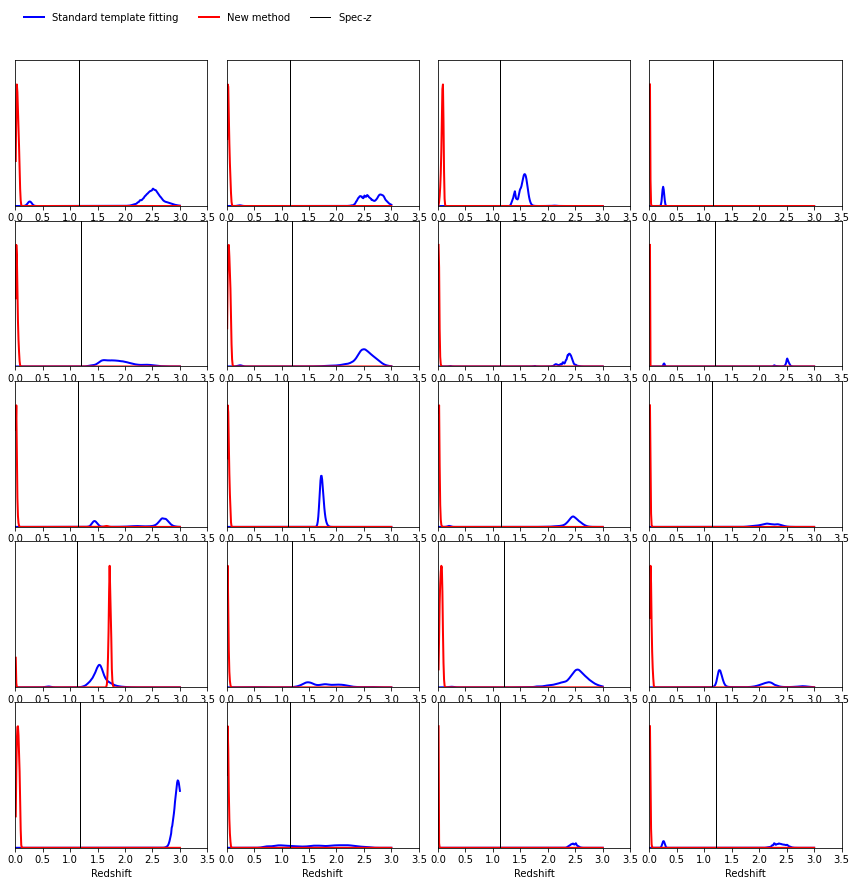

In [43]:
ncol = 4
fig, axs = plt.subplots(5, ncol, figsize=(12, 12), sharex=False, sharey=False)
axs = axs.ravel()
z = fluxredshifts[:, redshiftColumn]
sel = np.random.choice(nobj, axs.size, replace=False)
lw = 2
for ik in range(axs.size):
    k = sel[ik]
    print(k, end=" ")
    axs[ik].plot(redshiftGrid, pdfs_cww[k, :],lw=lw,color='b' ,label='Standard template fitting')# c="#2ecc71", 
    axs[ik].plot(redshiftGrid, pdfs[k, :], lw=lw, color="r",label='New method')  #, c="#3498db"
    axs[ik].axvline(fluxredshifts[k, redshiftColumn], c="k", lw=1, label=r'Spec-$z$')
    ymax = np.max(np.concatenate((pdfs[k, :], pdfs_cww[k, :])))
    axs[ik].set_ylim([0, ymax*1.2])
    axs[ik].set_xlim([0, 3.1])
    axs[ik].set_yticks([])
    axs[ik].set_xticks([0.0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5])
for i in range(ncol):
    axs[-i-1].set_xlabel('Redshift', fontsize=10)
axs[0].legend(ncol=3, frameon=False, loc='upper left', bbox_to_anchor=(0.0, 1.4))
fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.96)

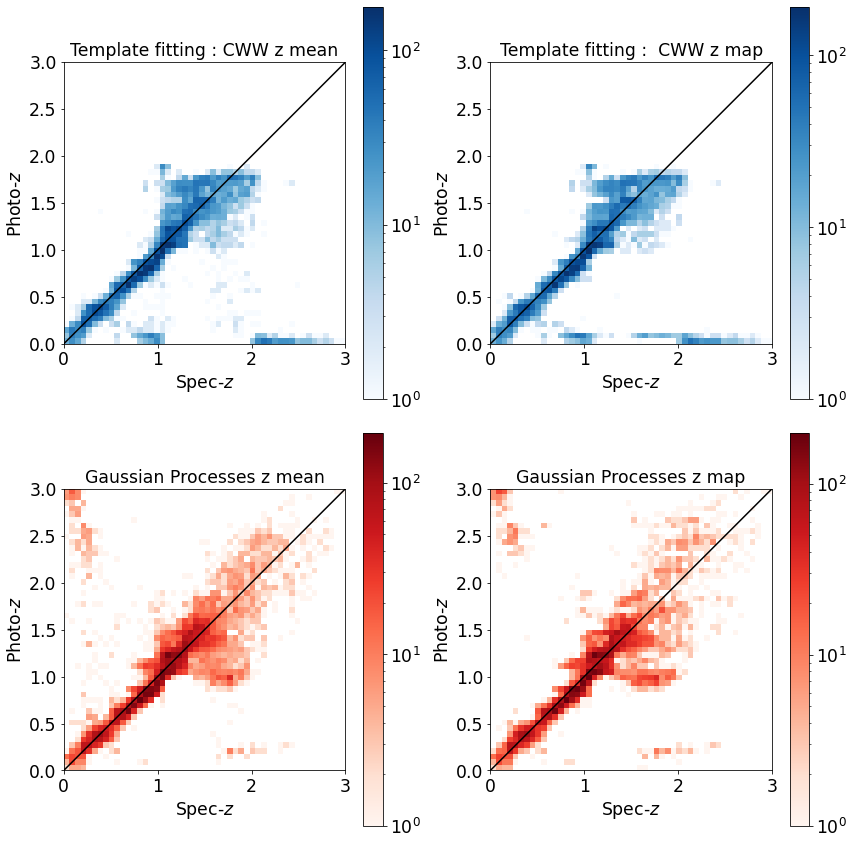

In [49]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
zmax = 3
rr = [[0, zmax], [0, zmax]]
nbins = 50
h = axs[0, 0].hist2d(metricscww_stack[:, i_zt], metricscww_stack[:, i_zm], nbins, cmap='Blues', range=rr,norm=LogNorm())
hmin, hmax = np.min(h[0]), np.max(h[0])
axs[0, 0].set_title('Template fitting : CWW z mean')
h2=axs[0, 1].hist2d(metricscww_stack[:, i_zt], metricscww_stack[:, i_zmap], nbins, cmap='Blues', range=rr,  norm=LogNorm())
axs[0, 1].set_title('Template fitting :  CWW z map')
h3=axs[1, 0].hist2d(metrics_stack[:, i_zt], metrics_stack[:, i_zm], nbins, cmap='Reds', range=rr,norm=LogNorm())
axs[1, 0].set_title('Gaussian Processes z mean')
h4=axs[1, 1].hist2d(metrics_stack[:, i_zt], metrics_stack[:, i_zmap], nbins, cmap='Reds', range=rr,norm=LogNorm())
axs[1, 1].set_title('Gaussian Processes z map')
axs[0, 0].plot([0, zmax], [0, zmax], c='k')
axs[0, 1].plot([0, zmax], [0, zmax], c='k')
axs[1, 0].plot([0, zmax], [0, zmax], c='k')
axs[1, 1].plot([0, zmax], [0, zmax], c='k')

fig.colorbar(h[3], ax=axs[0,0])
fig.colorbar(h2[3], ax=axs[0,1])
fig.colorbar(h3[3], ax=axs[1,0])
fig.colorbar(h4[3], ax=axs[1,1])


axs[0,0].set_xlabel('Spec-$z$')
axs[0,1].set_xlabel('Spec-$z$')
axs[1,0].set_xlabel('Spec-$z$')
axs[1,1].set_xlabel('Spec-$z$')

axs[0,0].set_ylabel('Photo-$z$')
axs[0,1].set_ylabel('Photo-$z$')
axs[1,0].set_ylabel('Photo-$z$')
axs[1,1].set_ylabel('Photo-$z$')

axs[0,0].set_aspect('equal')
axs[1,0].set_aspect('equal')
axs[0,1].set_aspect('equal')
axs[1,1].set_aspect('equal')


fig.tight_layout()


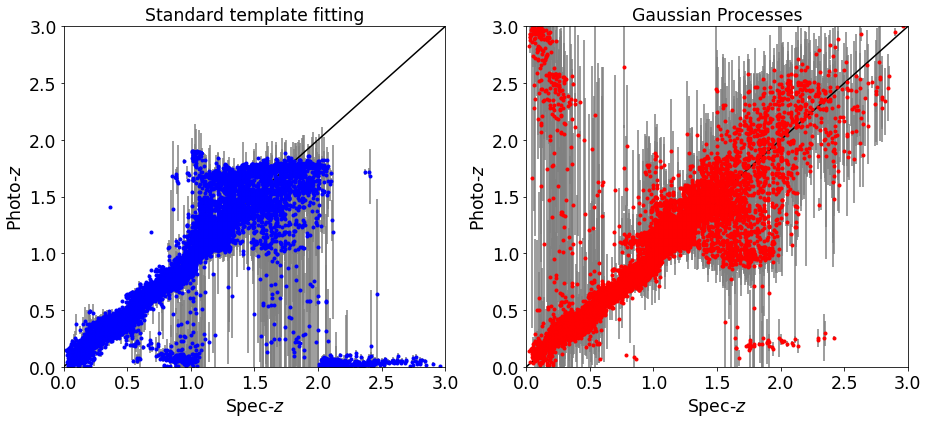

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(13, 6))
chi2s = ((metrics[:, i_zt] - metrics[:, i_ze])/metrics[:, i_std_ze])**2

axs[1].errorbar(metrics_stack[:, i_zt], metrics_stack[:, i_ze], yerr=metrics_stack[:, i_std_ze], fmt='o', markersize=3, color="r",ecolor='grey',capsize=0)
axs[0].errorbar(metricscww_stack[:, i_zt], metricscww_stack[:, i_ze], yerr=metricscww_stack[:, i_std_ze], fmt='o',color="b" ,ecolor='grey',markersize=3, capsize=0)
axs[0].plot([0, zmax], [0, zmax], 'k')
axs[1].plot([0, zmax], [0, zmax], 'k')
axs[0].set_xlim([0, zmax])
axs[1].set_xlim([0, zmax])
axs[0].set_ylim([0, zmax])
axs[1].set_ylim([0, zmax])
axs[1].set_title('Gaussian Processes')
axs[0].set_title('Standard template fitting')

axs[0].set_xlabel('Spec-$z$')
axs[0].set_ylabel('Photo-$z$')
axs[1].set_xlabel('Spec-$z$')
axs[1].set_ylabel('Photo-$z$')

fig.tight_layout()

Text(0.5, 1.0, 'Gaussian Processes')

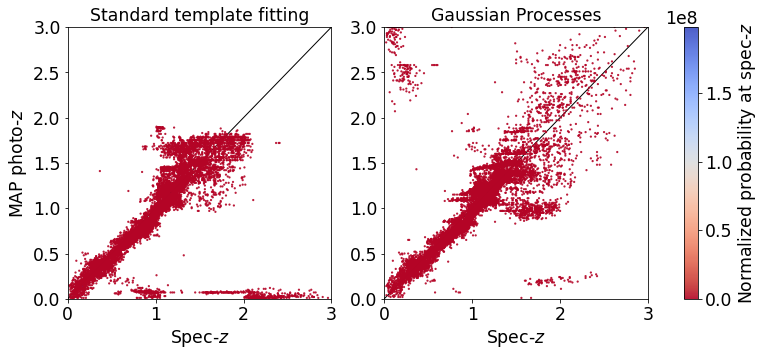

In [52]:
cmap = "coolwarm_r"
vmin = 0.0
alpha = 0.9
s = 5
fig, axs = plt.subplots(1, 2, figsize=(13, 5))
vs = axs[0].scatter(metricscww_stack[:, i_zt], metricscww_stack[:, i_zmap], 
                    s=s, c=pdfatZ_cww_stack, cmap=cmap, linewidth=0, vmin=vmin, alpha=alpha)
vs = axs[1].scatter(metrics_stack[:, i_zt], metrics_stack[:, i_zmap], 
                    s=s, c=pdfatZ_stack, cmap=cmap, linewidth=0, vmin=vmin, alpha=alpha)
clb = plt.colorbar(vs, ax=axs.ravel().tolist())
clb.set_label('Normalized probability at spec-$z$')
for i in range(2):
    axs[i].plot([0, zmax], [0, zmax], c='k', lw=1, zorder=0, alpha=1)
    axs[i].set_ylim([0, zmax])
    axs[i].set_xlim([0, zmax])
    axs[i].set_xlabel('Spec-$z$')
axs[0].set_ylabel('MAP photo-$z$')

axs[0].set_title('Standard template fitting')
axs[1].set_title('Gaussian Processes')

In [ ]:
assert False

In [ ]:
# First read a bunch of useful stuff from the parameter file.
params = parseParamFile(configfullfilename, verbose=False)
bandCoefAmplitudes, bandCoefPositions, bandCoefWidths, norms\
    = readBandCoefficients(params)
bandNames = params['bandNames']
numBands, numCoefs = bandCoefAmplitudes.shape
fluxredshifts = np.loadtxt(params['target_catFile'])
fluxredshifts_train = np.loadtxt(params['training_catFile'])
bandIndices, bandNames, bandColumns, bandVarColumns, redshiftColumn,\
            refBandColumn = readColumnPositions(params, prefix='target_')
redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)
dir_seds = params['templates_directory']
dir_filters = params['bands_directory']
lambdaRef = params['lambdaRef']
sed_names = params['templates_names']
nt = len(sed_names)
f_mod = np.zeros((redshiftGrid.size, nt, len(params['bandNames'])))
for t, sed_name in enumerate(sed_names):
    f_mod[:, t, :] = np.loadtxt(dir_seds + '/' + sed_name + '_fluxredshiftmod.txt')

In [ ]:
# Load the PDF files
metricscww = np.loadtxt(params['metricsFile'])
metrics = np.loadtxt(params['metricsFileTemp'])
# Those of the indices of the true, mean, stdev, map, and map_std redshifts.
i_zt, i_zm, i_std_zm, i_zmap, i_std_zmap = 0, 1, 2, 3, 4
i_ze = i_zm
i_std_ze = i_std_zm

pdfs = np.loadtxt(params['redshiftpdfFile'])
pdfs_cww = np.loadtxt(params['redshiftpdfFileTemp'])
pdfatZ_cww = metricscww[:, 5] / pdfs_cww.max(axis=1)
pdfatZ = metrics[:, 5] / pdfs.max(axis=1)
nobj = pdfatZ.size
#pdfs /= pdfs.max(axis=1)[:, None]
#pdfs_cww /= pdfs_cww.max(axis=1)[:, None]
pdfs /= np.trapz(pdfs, x=redshiftGrid, axis=1)[:, None]
pdfs_cww /= np.trapz(pdfs_cww, x=redshiftGrid, axis=1)[:, None]

In [ ]:
ncol = 4
fig, axs = plt.subplots(5, ncol, figsize=(10, 9), sharex=True, sharey=False)
axs = axs.ravel()
z = fluxredshifts[:, redshiftColumn]
sel = np.random.choice(nobj, axs.size, replace=False)
lw = 2
for ik in range(axs.size):
    k = sel[ik]
    print(k, end=" ")
    axs[ik].plot(redshiftGrid, pdfs_cww[k, :],lw=lw, label='Standard template fitting')# c="#2ecc71", 
    axs[ik].plot(redshiftGrid, pdfs[k, :], lw=lw, label='New method')  #, c="#3498db"
    axs[ik].axvline(fluxredshifts[k, redshiftColumn], c="k", lw=1, label='Spec-z')
    ymax = np.max(np.concatenate((pdfs[k, :], pdfs_cww[k, :])))
    axs[ik].set_ylim([0, ymax*1.2])
    axs[ik].set_xlim([0, 3.1])
    axs[ik].set_yticks([])
    axs[ik].set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])
for i in range(ncol):
    axs[-i-1].set_xlabel('Redshift', fontsize=10)
axs[0].legend(ncol=3, frameon=False, loc='upper left', bbox_to_anchor=(0.0, 1.4))
#fig.tight_layout()
#fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.96)


In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
zmax = 3.1
rr = [[0, zmax], [0, zmax]]
nbins = 30
h = axs[0, 0].hist2d(metricscww[:, i_zt], metricscww[:, i_zm], nbins, cmap='Greys', range=rr)
hmin, hmax = np.min(h[0]), np.max(h[0])
axs[0, 0].set_title('CWW z mean')
axs[0, 1].hist2d(metricscww[:, i_zt], metricscww[:, i_zmap], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[0, 1].set_title('CWW z map')
axs[1, 0].hist2d(metrics[:, i_zt], metrics[:, i_zm], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[1, 0].set_title('GP z mean')
axs[1, 1].hist2d(metrics[:, i_zt], metrics[:, i_zmap], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[1, 1].set_title('GP z map')
axs[0, 0].plot([0, zmax], [0, zmax], c='k')
axs[0, 1].plot([0, zmax], [0, zmax], c='k')
axs[1, 0].plot([0, zmax], [0, zmax], c='k')
axs[1, 1].plot([0, zmax], [0, zmax], c='k')
#fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5.5))
chi2s = ((metrics[:, i_zt] - metrics[:, i_ze])/metrics[:, i_std_ze])**2

axs[0].errorbar(metrics[:, i_zt], metrics[:, i_ze], yerr=metrics[:, i_std_ze], fmt='o', markersize=5, capsize=0)
axs[1].errorbar(metricscww[:, i_zt], metricscww[:, i_ze], yerr=metricscww[:, i_std_ze], fmt='o', markersize=5, capsize=0)
axs[0].plot([0, zmax], [0, zmax], 'k')
axs[1].plot([0, zmax], [0, zmax], 'k')
axs[0].set_xlim([0, zmax])
axs[1].set_xlim([0, zmax])
axs[0].set_ylim([0, zmax])
axs[1].set_ylim([0, zmax])
axs[0].set_title('New method')
axs[1].set_title('Standard template fitting')

fig.tight_layout()

In [ ]:
cmap = "coolwarm_r"
vmin = 0.0
alpha = 0.9
s = 5
fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))
vs = axs[0].scatter(metricscww[:, i_zt], metricscww[:, i_zmap], 
                    s=s, c=pdfatZ_cww, cmap=cmap, linewidth=0, vmin=vmin, alpha=alpha)
vs = axs[1].scatter(metrics[:, i_zt], metrics[:, i_zmap], 
                    s=s, c=pdfatZ, cmap=cmap, linewidth=0, vmin=vmin, alpha=alpha)
clb = plt.colorbar(vs, ax=axs.ravel().tolist())
clb.set_label('Normalized probability at spec-$z$')
for i in range(2):
    axs[i].plot([0, zmax], [0, zmax], c='k', lw=1, zorder=0, alpha=1)
    axs[i].set_ylim([0, zmax])
    axs[i].set_xlim([0, zmax])
    axs[i].set_xlabel('Spec-$z$')
axs[0].set_ylabel('MAP photo-$z$')

axs[0].set_title('Standard template fitting')
axs[1].set_title('New method')

## Conclusion
Don't be too harsh with the results of the standard template fitting or the new methods since both have a lot of parameters which can be optimized!

If the results above made sense, i.e. the redshifts are reasonnable for both methods on the mock data, then you can start modifying the parameter files and creating catalog files containing actual data! I recommend using less than 20k galaxies for training, and 1000 or 10k galaxies for the delight-apply script at the moment. Future updates will address this issue.